### Load Data (S&P 500 Stocks)

In [ ]:
import os
import warnings
import pandas as pd
import numpy as np
import pandas_ta as ta

def process_stock_data(folder_path, start_date='2000-01-01'):
    
    warnings.filterwarnings("ignore")
    
    # Get list of ticker names from CSV files
    tickers = [f[:-4] for f in os.listdir(folder_path) if f.endswith(".csv")]
    
    dfs = {}
    
    for ticker in tickers:
        file_path = os.path.join(folder_path, f"{ticker}.csv")
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error reading {ticker}: {e}")
            continue
            
        # Strip extra date info (e.g. exact time)
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'].astype(str).str.slice(0, 10), 
                                      errors='coerce')
        else:
            print(f"No 'Date' column found in {ticker}. Skipping.")
            continue
            
        required_cols = {'Date', 'Open', 'High', 'Low', 'Close'}
        if not required_cols.issubset(df.columns):
            print(f"Missing columns in {ticker}. Skipping.")
            continue
            
        df.set_index('Date', inplace=True)
        df = df[['Open', 'High', 'Low', 'Close']].sort_index()
        
        dfs[ticker] = df
    
    # Concatenate all DataFrames
    combined_df = pd.concat(dfs, axis=1)
    
    # Sort the combined DataFrame by date index
    combined_df.sort_index(inplace=True)
    
    # Convert wide format to long format
    long_df = combined_df.stack(level=0).reset_index()
    
    # Rename columns
    long_df.columns = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close']
    
    # Filter by start date
    long_df = long_df[long_df['Date'] > start_date].copy()
    
    return long_df

folder_path = r"C:\Users\6eggr\Desktop\Python\New folder\daily_data"
long_df = process_stock_data(folder_path, start_date='2015-01-01')
long_df.head(5)

,Date,Ticker,Open,High,Low,Close
3029828,2015-01-02,A,37.99,38.11,37.25,37.42
3029829,2015-01-02,AAPL,24.81,24.82,23.91,24.35
3029830,2015-01-02,ABBV,43.27,43.90,43.27,43.56
3029831,2015-01-02,ABT,37.40,37.56,36.89,37.11
3029832,2015-01-02,ACGL,18.76,18.88,18.47,18.54


### Create Features

In [27]:
def create_features(df):
    import numpy as np
    import pandas_ta as ta
    df = df.sort_values('Date')

    # RSI
    df['RSI'] = ta.rsi(df['Close'], length=14)

    # Bollinger Bands + BB Width
    df['20_MA'] = df['Close'].rolling(window=20).mean()
    df['20_STD'] = df['Close'].rolling(window=20).std()
    df['Upper_Band'] = df['20_MA'] + (1.5 * df['20_STD'])
    df['Lower_Band'] = df['20_MA'] - (1.5 * df['20_STD'])
    df['BB_Width'] = (df['Upper_Band'] - df['Lower_Band']) / df['Close']

    # Body Size + Relative Body Size
    period = 5
    df['Range'] = df['High'] - df['Low']  # Calculate range
    df['Range'].replace(0, np.nan, inplace=True)  # Replace zeros in the range with NaN
    df['BodySize'] = (df['Close'] - df['Open']) / df['Range']

    # Percent Change for short and long periods + Crossover
    short_period = 5
    long_period = 10
    df['Short_Change'] = df['Close'].pct_change(periods=short_period) * 100  # Look backward
    df['Long_Change'] = df['Close'].pct_change(periods=long_period) * 100  # Look backward
    df['Crossover'] = np.where(df['Short_Change'] > df['Long_Change'], 1, -1)

    # Moving Averages and EMAs
    df['5_EMA'] = ta.ema(df['Close'], length=5)
    df['10_MA'] = df['Close'].rolling(window=10).mean()
    df['20_MA'] = df['Close'].rolling(window=20).mean()  # Recalculate if not already defined
    df['50_MA'] = df['Close'].rolling(window=50).mean()

    # Drop intermediate columns
    df.drop(columns=['Range'], inplace=True)

    # Add percentage change over the past 1, 3, 6, and 12 months
    month_periods = {'1_Month': 21, '3_Months': 63, '6_Months': 126, '12_Months': 252}
    for label, period in month_periods.items():
        df[f'Pct_Change_{label}'] = df['Close'].pct_change(periods=period) * 100

    return df


In [28]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
long_df_features = long_df.groupby('Ticker', group_keys=False).apply(create_features)
long_df_features.dropna().head()

,Date,Ticker,Open,High,Low,Close,RSI,20_MA,20_STD,Upper_Band,Lower_Band,BB_Width,BodySize,Short_Change,Long_Change,Crossover,5_EMA,10_MA,50_MA,Pct_Change_1_Month,Pct_Change_3_Months,Pct_Change_6_Months,Pct_Change_12_Months
3148260,2016-01-04,A,38.29,38.41,37.62,37.94,49.82,38.30,0.62,39.23,37.37,0.05,-0.44,-3.18,0.05,-1,38.65,38.60,36.89,0.94,17.68,3.96,1.39
3148261,2016-01-04,AAPL,23.24,23.87,23.10,23.86,34.33,25.08,1.03,26.63,23.53,0.13,0.81,-2.48,-3.33,1,24.11,24.25,26.02,-9.40,-4.15,-15.65,-2.00
3148262,2016-01-04,ABBV,39.65,39.82,38.51,39.34,48.38,39.03,1.04,40.60,37.47,0.08,-0.23,-1.45,2.18,-1,39.99,39.70,39.78,-0.19,4.16,-14.14,-9.69
3148263,2016-01-04,ABT,37.09,37.18,35.87,36.23,38.12,37.94,0.63,38.89,36.99,0.05,-0.65,-4.81,-5.15,1,37.47,37.67,37.95,-5.06,4.35,-12.77,-2.36
3148264,2016-01-04,ACGL,21.81,22.08,21.51,21.82,31.73,22.39,0.38,22.97,21.82,0.05,0.02,-2.42,-1.54,-1,22.15,22.26,23.13,-5.46,-7.38,-0.65,17.71


### Create Binary Features

###### The theory behind the coding of the indicators is essentially anti mean reversion. For example, my observation is that when people say stocks are overbought based on a high RSI, they continue to go up significantly. This is more so true for volatile stocks or periods, and much less so for value type stocks so model performance is expected to reflect that.

In [29]:
def create_binary_features(df):
    df = df.copy()

    df['BodySize'] = np.where(df['BodySize'] > 0.5, 1,
                              np.where(df['BodySize'] < (-0.5), -1, 0))    
    df['RSI_Signal'] = np.where(df['RSI'] > 70, 1,
                                np.where(df['RSI'] < 30, -1, 0))
    df['Gap'] = np.where(df['Close'].pct_change(periods=1).fillna(0) > 0, 1, -1)
    df['Outside_Band'] = np.where(df['Close'] > df['Upper_Band'], 1,
                                  np.where(df['Close'] < df['Lower_Band'], -1, 0))
    df['Short_Change'] = np.where(df['Short_Change'] > 0, 1, -1)
    df['Long_Change'] = np.where(df['Long_Change'] > 0, 1, -1)
    df['Pct_Change_3_Months'] = np.where(df['Pct_Change_3_Months'] > 0, 1, -1)
    df['Pct_Change_1_Month'] = np.where(df['Pct_Change_1_Month'] > 0, 1, -1)
    df['Pct_Change_6_Months'] = np.where(df['Pct_Change_6_Months'] > 0, 1, -1)
    df['Pct_Change_12_Months'] = np.where(df['Pct_Change_12_Months'] > 0, 1, -1)

    # EMA and SMA slopes
    df['5_EMA_Slope'] = np.where(df['5_EMA'].diff().fillna(0) > 0, 1, -1)
    df['10_SMA_Slope'] = np.where(df['10_MA'].diff().fillna(0) > 0, 1, -1)
    df['50_SMA_Slope'] = np.where(df['50_MA'].diff().fillna(0) > 0, 1, -1)
    df['20_MA_Slope'] = np.where(df['20_MA'].diff().fillna(0) > 0, 1, -1)


    # Binary variables for price relative to SMAs
    df['Above_10_SMA'] = np.where(df['Close'] > df['10_MA'], 1, -1)
    df['Above_20_SMA'] = np.where(df['Close'] > df['20_MA'], 1, -1)
    df['Above_50_SMA'] = np.where(df['Close'] > df['50_MA'], 1, -1)

    # Binary columns
    binary_columns = ['BodySize', '20_MA_Slope', 'RSI_Signal', 'Gap', 'Outside_Band',
                      'Short_Change', 'Long_Change', 'Pct_Change_3_Months',
                      'Pct_Change_1_Month', 'Pct_Change_6_Months', 'Pct_Change_12_Months',
                      '5_EMA_Slope', '10_SMA_Slope', '50_SMA_Slope', 'Above_10_SMA',
                      'Above_20_SMA', 'Above_50_SMA']

    df['Vote_Count'] = df[binary_columns].sum(axis=1)

    columns_to_keep = ['Date', 'Ticker', 'Close', 'Open'] + binary_columns + ['Vote_Count']

    return df[columns_to_keep]


In [30]:
# Apply binary feature creation
binary_df = long_df_features.groupby('Ticker').apply(create_binary_features).reset_index(drop=True)
binary_df.head(20)

,Date,Ticker,Close,Open,BodySize,20_MA_Slope,RSI_Signal,Gap,Outside_Band,Short_Change,Long_Change,Pct_Change_3_Months,Pct_Change_1_Month,Pct_Change_6_Months,Pct_Change_12_Months,5_EMA_Slope,10_SMA_Slope,50_SMA_Slope,Above_10_SMA,Above_20_SMA,Above_50_SMA,Vote_Count
0,2015-01-02,A,37.42,37.99,-1,-1,0,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-15
1,2015-01-05,A,36.72,37.20,-1,-1,0,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-15
2,2015-01-06,A,36.15,36.73,-1,-1,0,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-15
3,2015-01-07,A,36.63,36.46,0,-1,0,1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-12
4,2015-01-08,A,37.73,37.13,1,-1,0,1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-11
5,2015-01-09,A,37.45,37.83,-1,-1,0,-1,0,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-11
6,2015-01-12,A,37.01,37.47,-1,-1,0,-1,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-13
7,2015-01-13,A,36.49,37.34,-1,-1,0,-1,0,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-13
8,2015-01-14,A,36.04,36.01,0,-1,0,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-14
9,2015-01-15,A,35.07,36.29,-1,-1,0,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-15


### Set up trading strategy (Long/Short with position rollover)

In [56]:
def simulate_trading(df, open_threshold=14, close_threshold=10):
    # Ensure the DataFrame is sorted by date
    df = df.sort_values("Date").copy()
    
    # Initialize new columns
    df["Trade_Activity"] = "None"
    df["Daily_Return"] = 0.0
    df["Cumulative_Return"] = 1.0

    # Initialize variables for tracking position and returns
    position = "None"
    entry_price = None
    cumulative_return = 1.0

    # Loop from the second row because we'll use the previous day's signal for today's trade decisions
    for i in range(1, len(df)):
        # Use the previous day's Vote_Count for signal generation
        prev_vote = df.loc[df.index[i - 1], "Vote_Count"]

        # At the open of day i, decide actions based on yesterday's signal
        if position == "None":
            if prev_vote >= open_threshold:
                position = "Long"
                entry_price = df.loc[df.index[i], "Open"]
                df.at[df.index[i], "Trade_Activity"] = "Open_Long"
            elif prev_vote <= -open_threshold:
                position = "Short"
                entry_price = df.loc[df.index[i], "Open"]
                df.at[df.index[i], "Trade_Activity"] = "Open_Short"
            else:
                df.at[df.index[i], "Trade_Activity"] = "None"

        elif position == "Long":
            # If conditions to hold are not met, close the long position at today's open
            if prev_vote >= close_threshold:
                df.at[df.index[i], "Trade_Activity"] = "Hold_Long"
            else:
                # Close Long position at today's open
                exit_price = df.loc[df.index[i], "Open"]
                df.at[df.index[i], "Trade_Activity"] = "Close_Long"
                position = "None"
                entry_price = None

        elif position == "Short":
            # If conditions to hold are not met, close the short position at today's open
            if prev_vote <= -close_threshold:
                df.at[df.index[i], "Trade_Activity"] = "Hold_Short"
            else:
                # Close Short position at today's open
                exit_price = df.loc[df.index[i], "Open"]
                df.at[df.index[i], "Trade_Activity"] = "Close_Short"
                position = "None"
                entry_price = None

        # Determine the current position after today's open decisions
        current_position = position

        # For positions held overnight, add previous close to current open move
        if current_position == "Long":
            overnight_ret = (df.loc[df.index[i], "Open"] / df.loc[df.index[i-1], "Close"]) - 1 if df.at[df.index[i], "Trade_Activity"] == "Hold_Long" else 0
            intraday_ret = (df.loc[df.index[i], "Close"] / df.loc[df.index[i], "Open"]) - 1
            daily_ret = overnight_ret + intraday_ret + (overnight_ret * intraday_ret)
        elif current_position == "Short":
            overnight_ret = (df.loc[df.index[i-1], "Close"] / df.loc[df.index[i], "Open"]) - 1 if df.at[df.index[i], "Trade_Activity"] == "Hold_Short" else 0
            intraday_ret = (df.loc[df.index[i], "Open"] / df.loc[df.index[i], "Close"]) - 1
            daily_ret = overnight_ret + intraday_ret + (overnight_ret * intraday_ret)
        else:
            daily_ret = 0.0

        # Update the DataFrame with daily and cumulative returns
        df.at[df.index[i], "Daily_Return"] = daily_ret
        cumulative_return *= (1 + daily_ret)
        df.at[df.index[i], "Cumulative_Return"] = cumulative_return

    # At the end of simulation, if a position remains open, close it at the last day's close
    if position != "None" and entry_price is not None:
        # Use the last day's prices to finalize returns for the open position
        final_open = df.iloc[-1]["Open"]
        final_close = df.iloc[-1]["Close"]
        if position == "Long":
            last_day_ret = (final_close / final_open) - 1
            df.at[df.index[-1], "Trade_Activity"] = "Close_Long_End"
        elif position == "Short":
            last_day_ret = (final_open / final_close) - 1
            df.at[df.index[-1], "Trade_Activity"] = "Close_Short_End"

        cumulative_return *= (1 + last_day_ret)
        df.at[df.index[-1], "Daily_Return"] = last_day_ret
        df.at[df.index[-1], "Cumulative_Return"] = cumulative_return

    return df[["Date", "Ticker", "Open", "Close", "Vote_Count", "Trade_Activity", "Daily_Return", "Cumulative_Return"]]


### Run the strategy

In [57]:
trades_df = binary_df.groupby('Ticker').apply(simulate_trading)
trades_df.set_index('Date', inplace=True)

### Visualizing AAPL Performance (strategy does not include fees)

In [58]:
trades_df[trades_df['Ticker'] == 'AAPL'].head(25)

,Ticker,Open,Close,Vote_Count,Trade_Activity,Daily_Return,Cumulative_Return
Date,,,,,,,
2015-01-02,AAPL,24.81,24.35,-15,None,0.00,1.00
2015-01-05,AAPL,24.12,23.66,-15,Open_Short,0.02,1.02
2015-01-06,AAPL,23.73,23.66,-12,Hold_Short,-0.00,1.02
2015-01-07,AAPL,23.87,24.00,-12,Hold_Short,-0.01,1.01
2015-01-08,AAPL,24.32,24.92,-11,Hold_Short,-0.04,0.97
2015-01-09,AAPL,25.09,24.94,-8,Hold_Short,-0.00,0.97
2015-01-12,AAPL,25.08,24.33,-13,Close_Short,0.00,0.97
2015-01-13,AAPL,24.81,24.55,-8,None,0.00,0.97
2015-01-14,AAPL,24.28,24.45,-10,None,0.00,0.97


<Axes: xlabel='Date'>

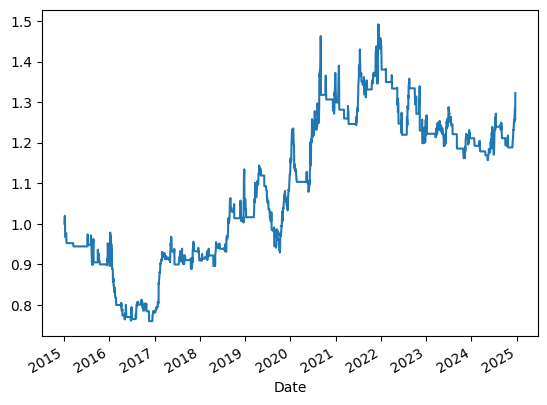

In [59]:
trades_df['Cumulative_Return'][trades_df['Ticker'] == 'AAPL'].plot()

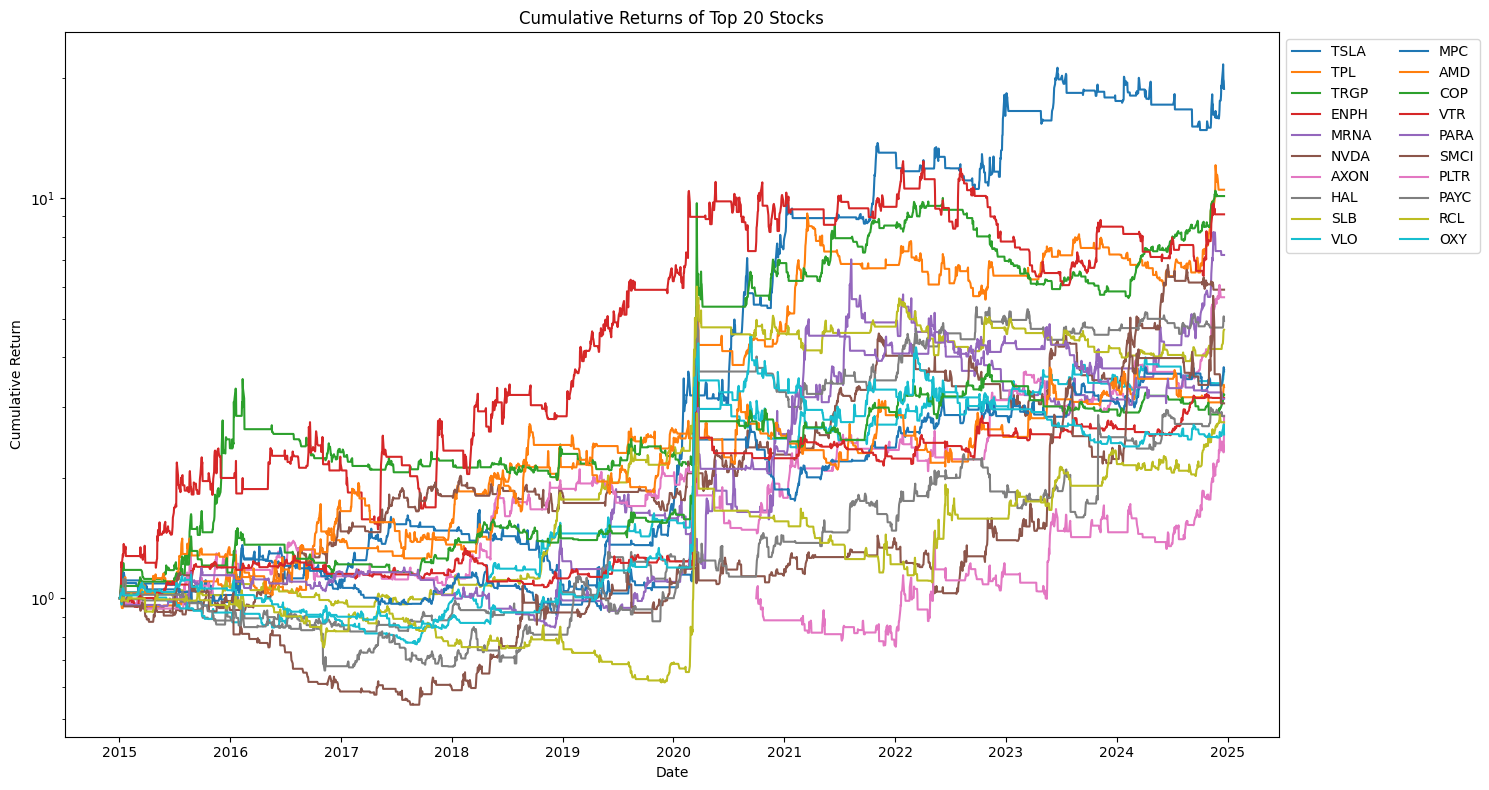

In [60]:
import matplotlib.pyplot as plt

final_cumulative_returns = trades_df.groupby('Ticker').last()['Cumulative_Return']

top_20_tickers = final_cumulative_returns.sort_values(ascending=False).head(20).index

top_20_trades = trades_df[trades_df['Ticker'].isin(top_20_tickers)]

plt.figure(figsize=(15, 8))
for ticker in top_20_tickers:
    stock_data = top_20_trades[top_20_trades['Ticker'] == ticker]
    plt.plot(stock_data['Cumulative_Return'], label=ticker)

# Add labels and legend
plt.title('Cumulative Returns of Top 20 Stocks')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
plt.yscale('log')
plt.tight_layout()
plt.show()


### Now an Ensemble of (Random) Models

In [61]:
import random

def generate_model_votes(df, num_models, num_indicators, model_threshold):
    #Generate votes from randomly selected sets of indicators with an integer threshold
    indicators = [col for col in df.columns if col not in ["Date", "Target", "Ticker", "Close", "Vote_Count"]]
    model_votes = []
    
    for i in range(num_models):
        selected_indicators = random.sample(indicators, num_indicators)
        # Count positive and negative contributions from selected indicators
        df[f"Model_Vote_{i}"] = df[selected_indicators].sum(axis=1).apply(
            lambda x: 1 if x >= model_threshold else (-1 if x <= -model_threshold else 0)
        )
        model_votes.append(f"Model_Vote_{i}")
    
    # Aggregate all model votes into a final vote count
    df["Vote_Count"] = df[model_votes].sum(axis=1)
    return df


def simulate_trading_with_models(df, num_models, num_indicators, open_threshold, close_threshold, model_threshold):
    # Generate model votes and aggregate
    df = generate_model_votes(df, num_models, num_indicators, model_threshold)
    
    # Sort DataFrame
    df = df.sort_values("Date").copy()

    # Initialize new columns
    df["Trade_Activity"] = "None"
    df["Daily_Return"] = 0.0
    df["Cumulative_Return"] = 1.0  

    # Track the current position 
    position = "None"
    entry_price = None
    cumulative_return = 1.0  

    for i in range(len(df)):
        vote = df.loc[df.index[i], "Vote_Count"]
        
        # Store the position status 
        position_start_of_day = position

        # No position: decide whether to open a new one 
        if position == "None":
            if vote >= open_threshold:
                position = "Long"
                entry_price = df.loc[df.index[i], "Close"]
                df.at[df.index[i], "Trade_Activity"] = "Open_Long"
            elif vote <= -open_threshold:
                position = "Short"
                entry_price = df.loc[df.index[i], "Close"]
                df.at[df.index[i], "Trade_Activity"] = "Open_Short"
            else:
                df.at[df.index[i], "Trade_Activity"] = "None"

        # Long position: decide whether to hold or close it at today's close
        elif position == "Long":
            if vote >= close_threshold:
                df.at[df.index[i], "Trade_Activity"] = "Hold_Long"
            else:
                # Close long position at today's close
                exit_price = df.loc[df.index[i], "Close"]
                df.at[df.index[i], "Trade_Activity"] = "Close_Long"
                position = "None"
                entry_price = None

        # Short position: decide whether to hold or close it at today's close
        elif position == "Short":
            if vote <= -close_threshold:
                df.at[df.index[i], "Trade_Activity"] = "Hold_Short"
            else:
                # Close short position at today's close
                exit_price = df.loc[df.index[i], "Close"]
                df.at[df.index[i], "Trade_Activity"] = "Close_Short"
                position = "None"
                entry_price = None

        # Calculate daily return based on the position held from yesterday
        if i > 0:
            if position_start_of_day == "Long":
                # If holding long from yesterday, compute return for today
                daily_ret = (df.loc[df.index[i], "Close"] / df.loc[df.index[i - 1], "Close"]) - 1
            elif position_start_of_day == "Short":
                # If holding short from yesterday, compute return for today
                daily_ret = (df.loc[df.index[i - 1], "Close"] / df.loc[df.index[i], "Close"]) - 1
            else:
                daily_ret = 0.0
            df.at[df.index[i], "Daily_Return"] = daily_ret
            # Update cumulative return only if there's a position from yesterday
            cumulative_return *= (1 + daily_ret)
        else:
            # First day so daily return is 0
            df.at[df.index[i], "Daily_Return"] = 0.0

        # Store the cumulative return
        df.at[df.index[i], "Cumulative_Return"] = cumulative_return

    # After loop: if a position remains open, close it at the last available price
    if position != "None" and entry_price is not None:
        final_price = df.iloc[-1]["Close"]
        if position == "Long":
            # Realize returns from closing a long position
            cumulative_return *= final_price / entry_price
            df.at[df.index[-1], "Trade_Activity"] = "Close_Long_End"
        elif position == "Short":
            # Realize returns from closing a short position
            cumulative_return *= entry_price / final_price
            df.at[df.index[-1], "Trade_Activity"] = "Close_Short_End"
        df.at[df.index[-1], "Cumulative_Return"] = cumulative_return

    return df[["Date", "Ticker", "Close", "Vote_Count", "Trade_Activity", "Daily_Return", "Cumulative_Return"]]



In [62]:
trades_df_ens = binary_df.groupby('Ticker').apply(
    lambda group: simulate_trading_with_models(
        group, 
        num_models=50, 
        num_indicators=10, 
        open_threshold=45, 
        close_threshold=40,
        model_threshold=5
    )
)
trades_df_ens.set_index('Date', inplace=True)


### Trade log example

In [87]:
trades_df_ens[trades_df['Ticker'] == 'AAPL'].tail(50)

,Ticker,Close,Vote_Count,Trade_Activity,Daily_Return,Cumulative_Return,Return
Date,,,,,,,
2024-10-11,AAPL,227.30,28,Close_Long,-0.01,2.42,-0.01
2024-10-14,AAPL,231.05,42,None,0.00,2.42,0.00
2024-10-15,AAPL,233.59,50,Open_Long,0.00,2.42,0.00
2024-10-16,AAPL,231.53,50,Hold_Long,-0.01,2.40,-0.01
2024-10-17,AAPL,231.89,50,Hold_Long,0.00,2.40,0.00
2024-10-18,AAPL,234.74,50,Hold_Long,0.01,2.43,0.01
2024-10-21,AAPL,236.22,50,Hold_Long,0.01,2.45,0.01
2024-10-22,AAPL,235.60,50,Hold_Long,-0.00,2.44,-0.00
2024-10-23,AAPL,230.51,32,Close_Long,-0.02,2.39,-0.02


### Results for best 20 Sharpe

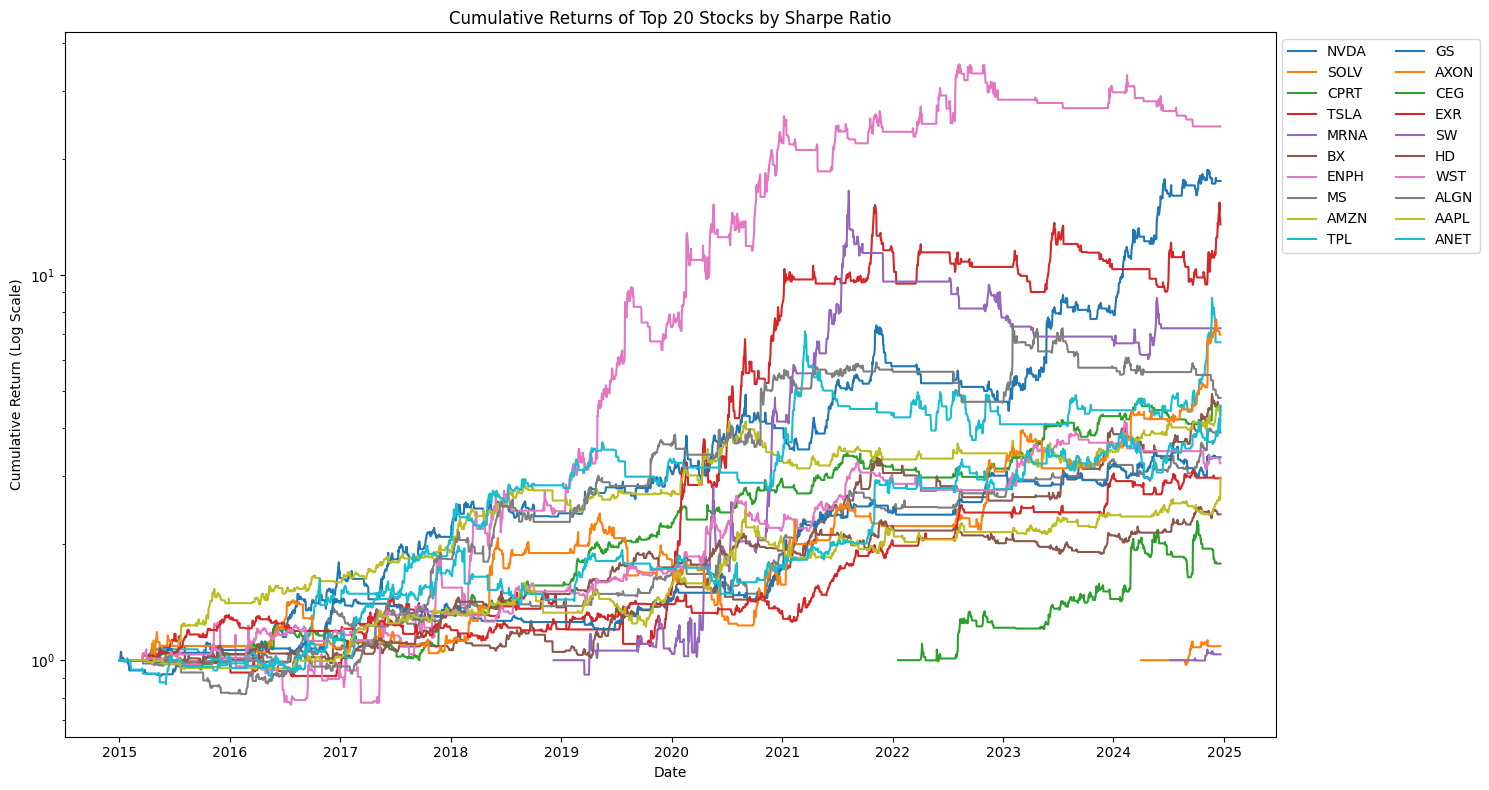

In [70]:
# Get daily returns and assume 2% annual risk-free rate
trades_df_ens['Return'] = trades_df_ens['Daily_Return'] 
rf_daily = (1 + 0.02) ** (1/252) - 1

# Calculate annualized Sharpe ratio 
excess_returns = trades_df_ens.groupby('Ticker')['Return'].mean() - rf_daily
sharpe_ratios = (excess_returns * 252) / (trades_df_ens.groupby('Ticker')['Return'].std() * np.sqrt(252))

# Sort and get top 20 tickers
top_sharpe_tickers = sharpe_ratios.sort_values(ascending=False).head(20).index
top_sharpe_trades = trades_df_ens[trades_df_ens['Ticker'].isin(top_sharpe_tickers)]

# Plot cumulative returns
plt.figure(figsize=(15, 8))
for ticker in top_sharpe_tickers:
   stock_data = top_sharpe_trades[top_sharpe_trades['Ticker'] == ticker]
   plt.plot(stock_data['Cumulative_Return'], label=ticker)

plt.yscale('log')
plt.title('Cumulative Returns of Top 20 Stocks by Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Log Scale)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
plt.tight_layout()
plt.show()

###### The takeaway from above is that the single models are still trading too much, but given that the baseline/non trained models CAN provide some signal, it is possible that well parameterized models could be valuable. My belief is that with the right framework, as # of trades goes down, winrate should go up. When we have thousands of markets to trade it makes sense to only trade those that currently have the highest probability of success. The goal of the features (and thresholding) was to restrict the model to only trade in optimal conditions, but the # of trades being placed suggests it fails to be restrictive enough. Theoretically, if we can find sets of highly profitable conditions that only happen 1 or 2 times a year on average per stock for example, we can scale those across 1,000+ stocks. Low frequency of signals in such an approach could be a significant edge as most people are trying to maximize the # of signals (for psychological reasons, e.g. overtrading and wanting to be able to predict every single move, as well as for statistical significance). This is where ML and a significant amount of compute could be very valuable.

### IDEAS

###### Volatility grouping: To train models across markets we can create groups of equities/assets with similar volatility distributions but uncorrelated price data with the goal of uncorrelated returns and models robust to overfitting. We can also do something similar where we identify volatile market environments across all markets and only use small chunks of price data where volatility is above a threshold to train. Then the models can trade any selected markets, but would only trigger on markets where volatility is above/below our threshold.

###### Fundamental data: Small/Mid cap companies seem to be more correlated with their underlying performance while conglomerates (Amazon, or even Stabucks/McDonalds) are driven by more complex economic phenomenon. For the former we can objectively categorize variables like cash/debt, Earnings/revenue revisions % up/down as bullish or bearish in binary variables to use in conjuction with technical indicators. (For mature companies cash/debt is mostly noise, but for a company with a 2B mkt cap, 1.5B in debt, 200M in cash and negative earnings that's a very bearish signal.) The key to fundamental data to me is that most of it is useless when you can make an argument that it is good or bad (e.g. Valuation metrics - overvaluation = bearish, or overvaluation is a sign of high demand = bullish)

###### On anti-mean reversion and low frequency signals -- I've spent a lot of time staring at charts, playing with Elliott Wave Theory (EWT), and watching how others trade. One key aspect of EWT is differentiating between impulses and corrections, but nearly everybody fails at this. Basically, corrections are states of mean reversion while impulses are states of 'trend'. I prefer to think in terms of anti-mean reversion because when prices get into the +2 STD area they are almost pulled magnetically (and very predictably!!!) towards those 3-4 STD moves for reasons other than simple trend following (and for reasons that I don't quite understand, but it's likely that the truly contrarian and high probability thing to do is to buy the stock making a 3 STD move up for example). 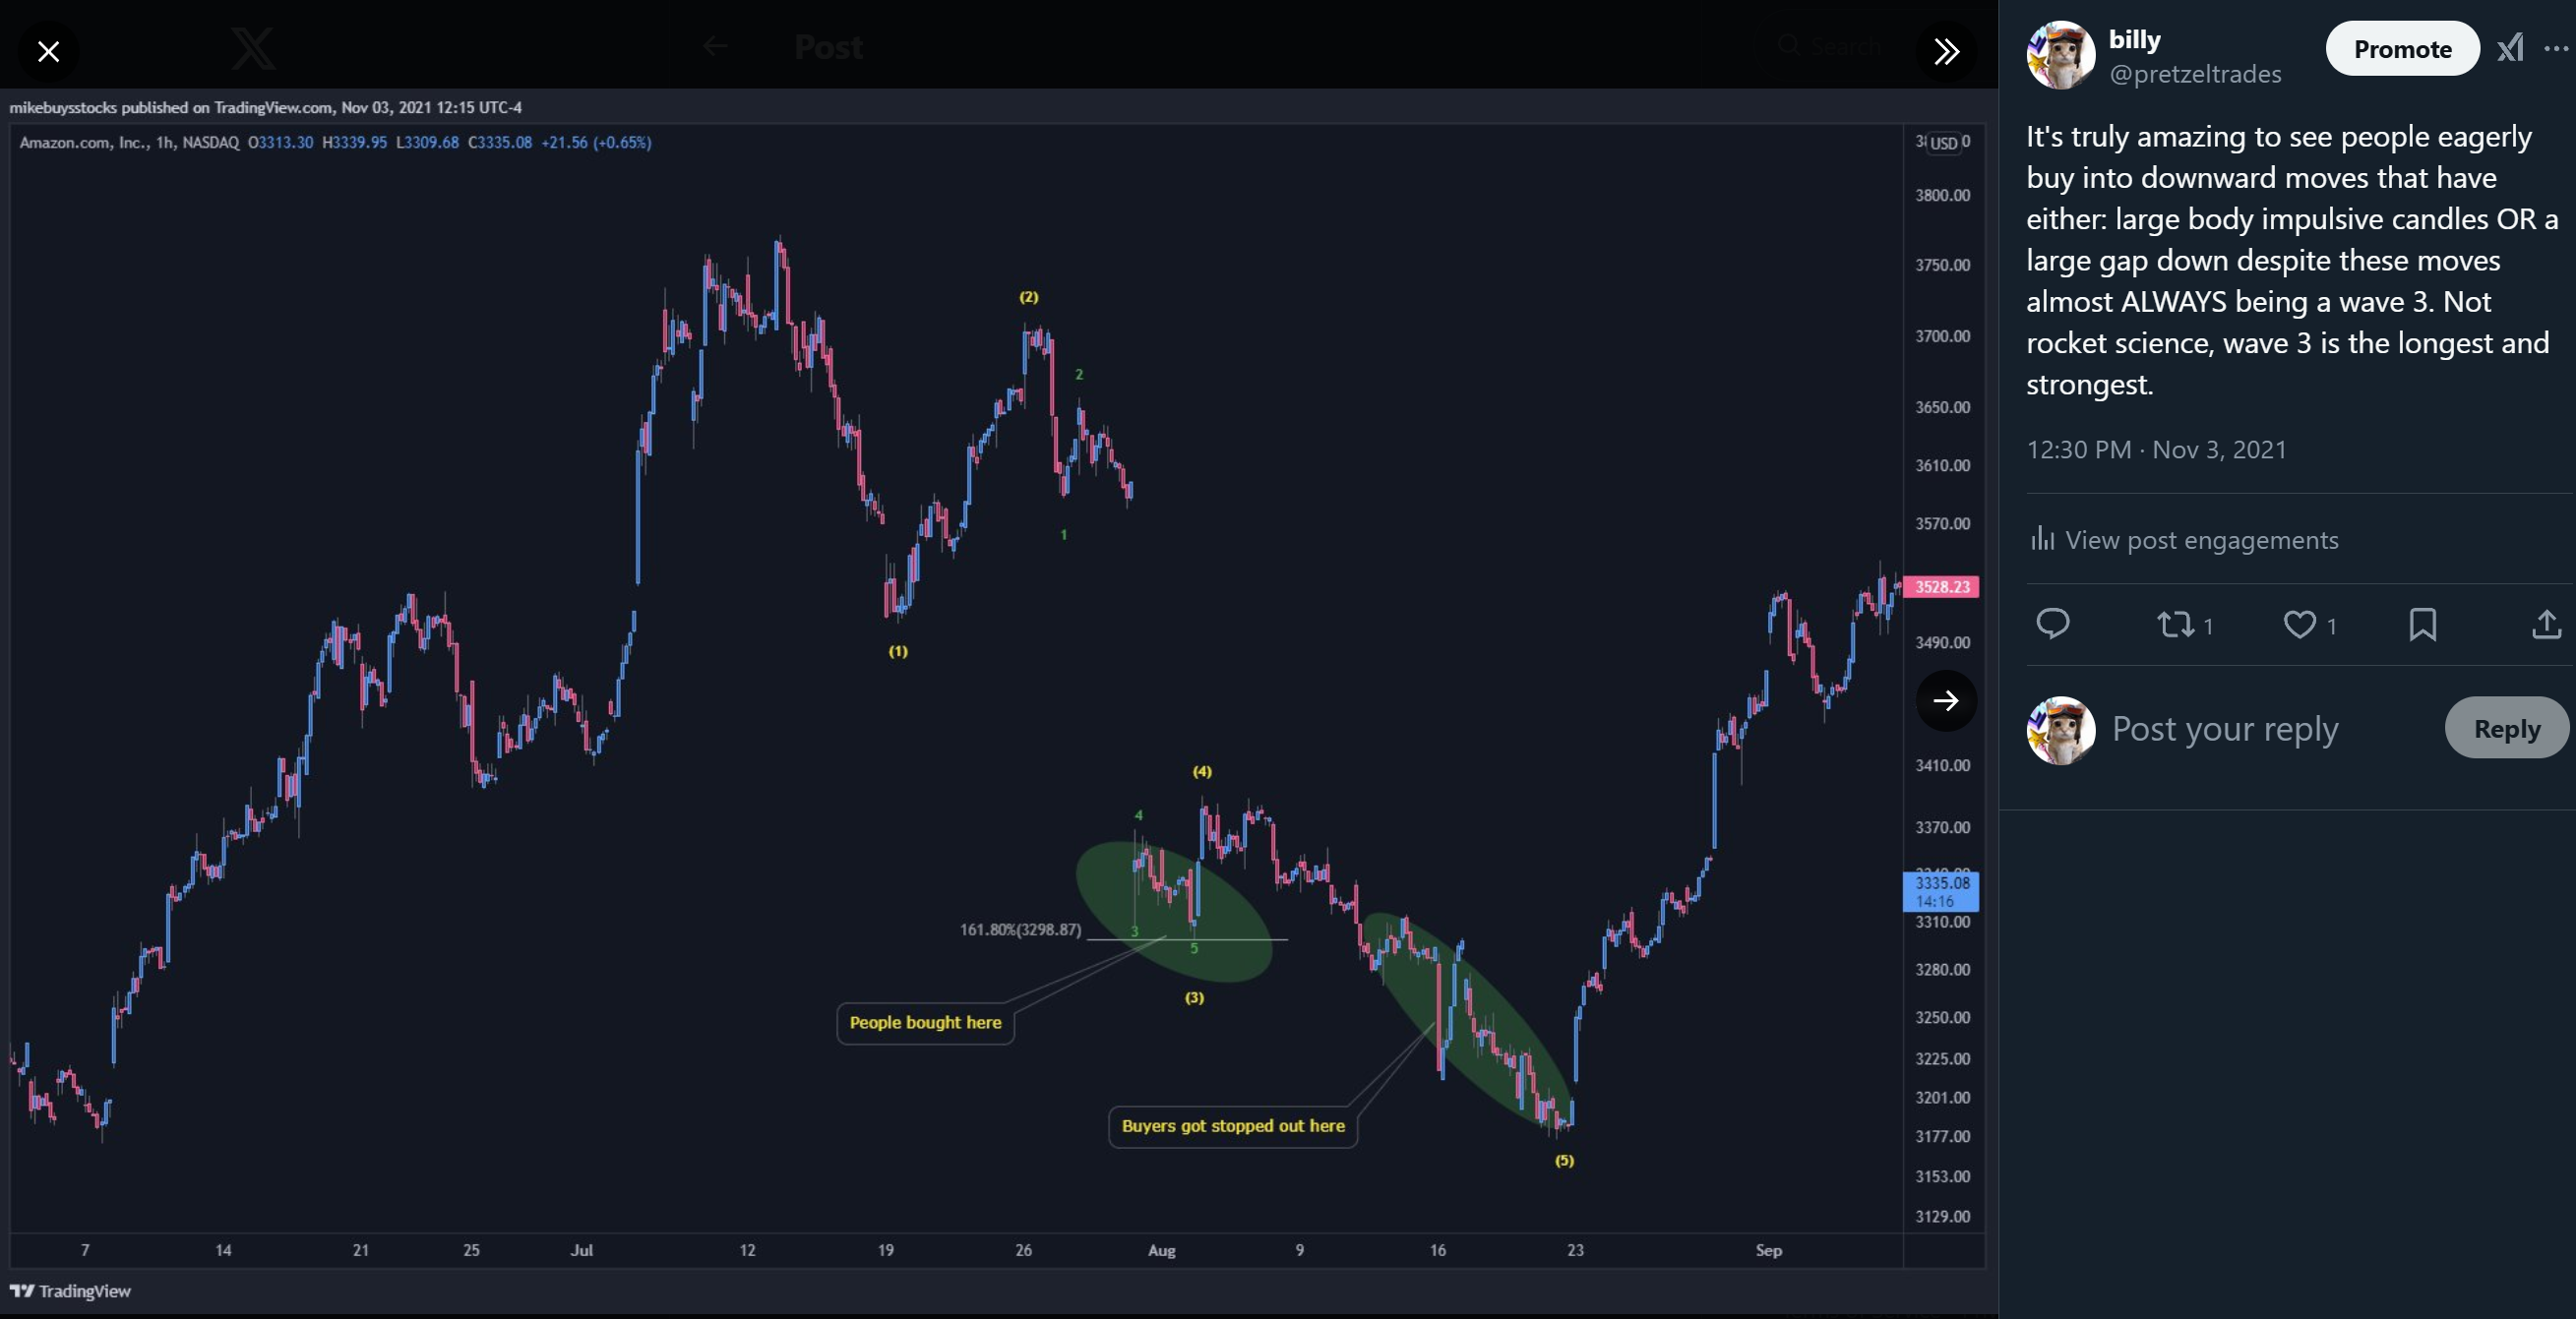

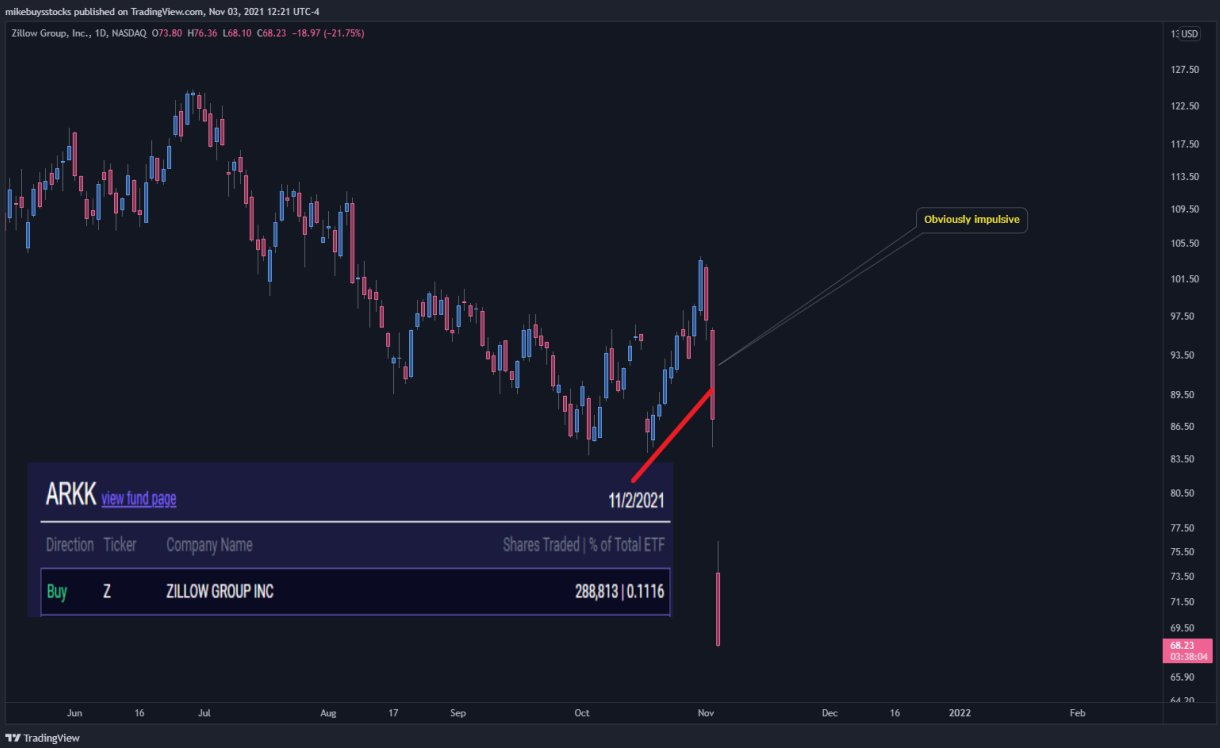

### Appendix: Evaluating baseline performance on stocks with highest monthly standard deviation

In [65]:
def get_top_volatile_stocks(df, n=20):
    
    df['Date'] = pd.to_datetime(df['Date'])
    
    df['Month'] = df['Date'].dt.to_period('M')
    
    df = df.sort_values(['Ticker', 'Date'])
    df['Daily_Return'] = df.groupby('Ticker')['Close'].pct_change()
    
    monthly_volatility = df.groupby(['Ticker', 'Month'])['Daily_Return'].std()
    
    avg_monthly_volatility = monthly_volatility.groupby('Ticker').mean()
    
    top_volatile = avg_monthly_volatility.sort_values(ascending=False).head(n)
    
    result = pd.DataFrame({
        'Ticker': top_volatile.index,
        'Avg_Monthly_Volatility': top_volatile.values
    })
    
    result['Avg_Monthly_Volatility'] = (result['Avg_Monthly_Volatility'] * 100).round(2)
    
    return result

top_20_volatile = get_top_volatile_stocks(long_df)
print(', '.join(f"'{ticker}'" for ticker in top_20_volatile['Ticker']))

'AMTM', 'ENPH', 'MRNA', 'PLTR', 'SMCI', 'CRWD', 'AMD', 'TSLA', 'FCX', 'UBER', 'APA', 'CZR', 'NCLH', 'GEV', 'ABNB', 'FSLR', 'BLDR', 'DVN', 'NVDA', 'MU'


### Apply the strategy

In [66]:
tickers = ['AMTM', 'ENPH', 'MRNA', 'PLTR', 'SMCI', 
           'CRWD', 'AMD', 'TSLA', 'FCX', 'UBER', 'APA', 'CZR', 'NCLH', 'GEV', 'ABNB', 'FSLR', 'BLDR', 'DVN', 'NVDA', 'MU']

trades_df_se = binary_df[binary_df['Ticker'].isin(tickers)].groupby('Ticker').apply(simulate_trading)
trades_df_se.set_index('Date', inplace=True)
trades_df_se.head()

,Ticker,Open,Close,Vote_Count,Trade_Activity,Daily_Return,Cumulative_Return
Date,,,,,,,
2020-12-10,ABNB,146.00,144.71,-14,None,0.00,1.00
2020-12-11,ABNB,146.55,139.25,-14,Open_Short,0.05,1.05
2020-12-14,ABNB,135.00,130.00,-14,Hold_Short,0.07,1.13
2020-12-15,ABNB,126.69,124.80,-14,Hold_Short,0.04,1.17
2020-12-16,ABNB,125.83,137.99,-11,Hold_Short,-0.10,1.06


### Plot returns

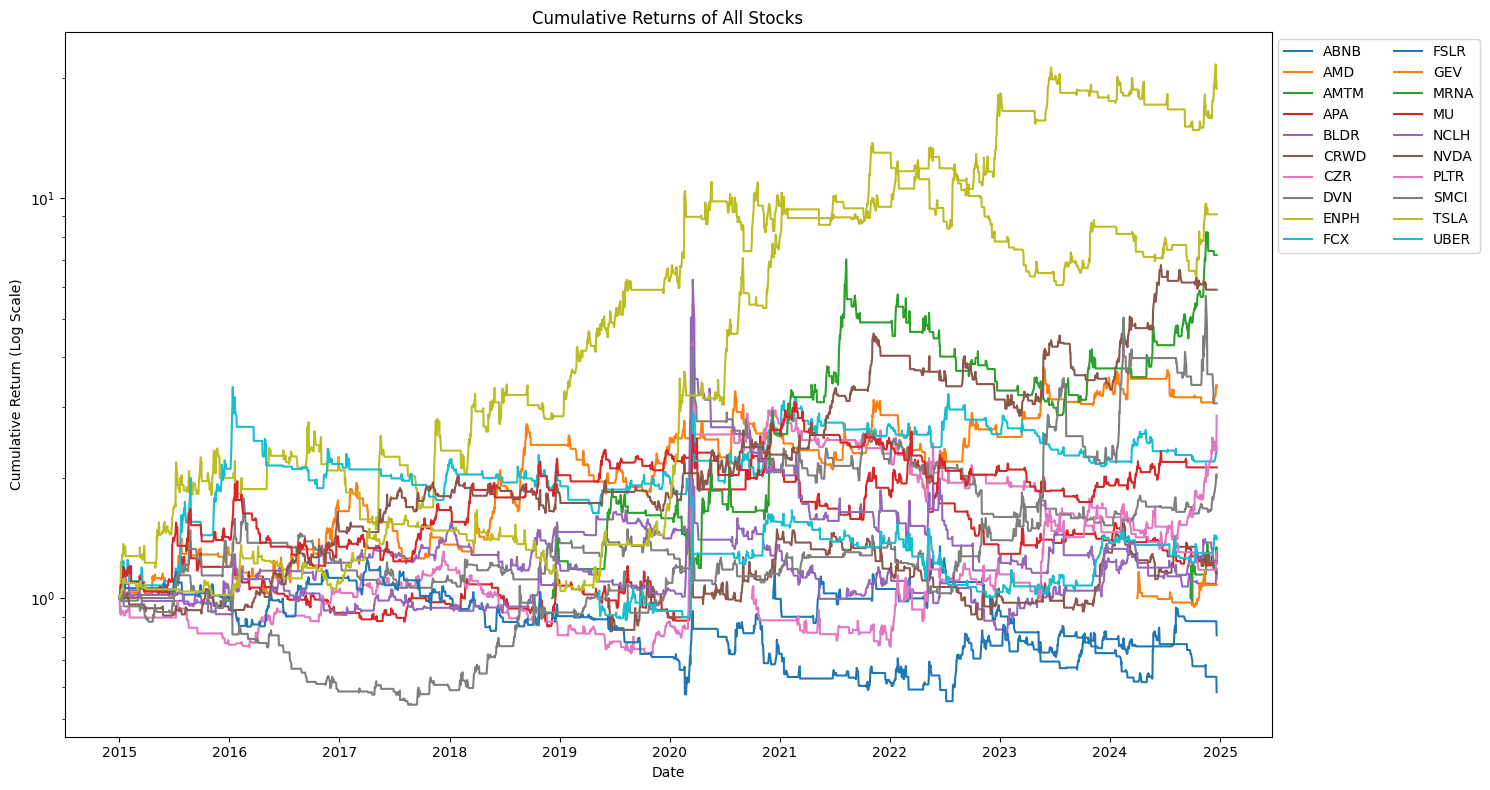

In [67]:
trades_df_se['Return'] = trades_df_se.groupby('Ticker')['Cumulative_Return'].pct_change()

plt.figure(figsize=(15, 8))
for ticker in trades_df_se['Ticker'].unique():
    stock_data = trades_df_se[trades_df_se['Ticker'] == ticker]
    plt.plot(stock_data['Cumulative_Return'], label=ticker)

plt.yscale('log')
plt.title('Cumulative Returns of All Stocks')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Log Scale)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
plt.tight_layout()
plt.show()
